In [104]:
# Як дохід для кожного способу оплати змінюється з часом? Які способи оплати забезпечують найбільший внесок наш щоденний дохід?

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import sum as _sum, col, to_date
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [105]:
spark = SparkSession.builder \
    .appName("TripDurationAnalysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

In [106]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")


In [107]:
df = df_trip.join(df_fare, ["medallion", "hack_license", "pickup_datetime"])

df_daily = df.withColumn("date", to_date(col("pickup_datetime")))

df_daily_profit = df_daily.groupBy("date", "payment_type") \
    .agg(_sum("total_amount").alias("daily_profit"))

window_spec = Window.partitionBy("payment_type").orderBy("date") \
                    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

df_cumulative = df_daily_profit.withColumn("cumulative_profit", _sum("daily_profit").over(window_spec))

df_cumulative.orderBy("payment_type", "date").show(truncate=False)


+----------+------------+------------------+--------------------+
|date      |payment_type|daily_profit      |cumulative_profit   |
+----------+------------+------------------+--------------------+
|2013-01-01|CRD         |2834284.2600000054|2834284.2600000054  |
|2013-01-02|CRD         |2846394.5200000033|5680678.780000009   |
|2013-01-03|CRD         |3202603.600000001 |8883282.38000001    |
|2013-01-04|CRD         |3485614.510000001 |1.2368896890000012E7|
|2013-01-05|CRD         |3336872.42        |1.5705769310000012E7|
|2013-01-06|CRD         |3143234.7800000026|1.8849004090000015E7|
|2013-01-07|CRD         |3279633.3600000003|2.2128637450000014E7|
|2013-01-08|CRD         |3586194.51        |2.5714831960000016E7|
|2013-01-09|CRD         |3773388.84        |2.9488220800000016E7|
|2013-01-10|CRD         |4179471.8399999933|3.366769264000001E7 |
|2013-01-11|CRD         |4329148.069999992 |3.799684071E7       |
|2013-01-12|CRD         |3825244.1399999973|4.182208485E7       |
|2013-01-1

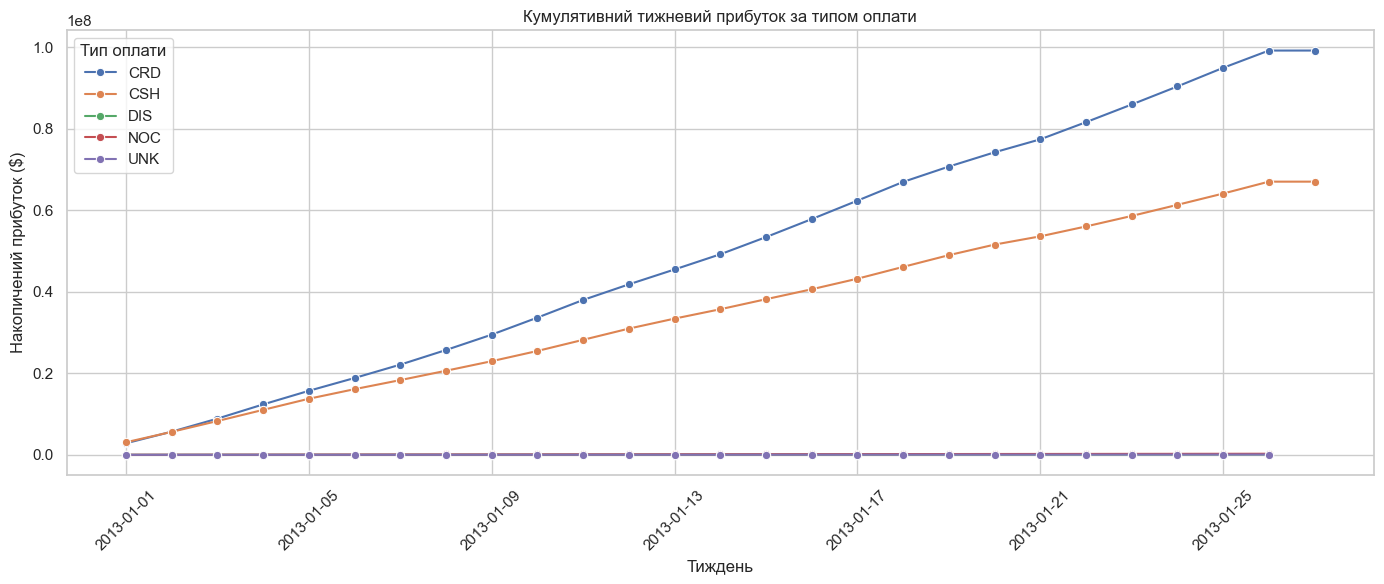

In [108]:
pdf = df_cumulative.orderBy("date", "payment_type").toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))
sns.lineplot(data=pdf, x="date", y="cumulative_profit", hue="payment_type", marker="o")

plt.title("Кумулятивний тижневий прибуток за типом оплати")
plt.xlabel("Тиждень")
plt.ylabel("Накопичений прибуток ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Тип оплати")
plt.show()

In [109]:
df_cumulative.coalesce(1).write.option("header", True).mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/6.csv")